In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os





2024-11-10 12:07:29.152239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 12:07:30.476070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
def load_mfcc_data(base_path, max_len=None):
    """
    Load MFCC data from CSV files with variable lengths
    Args:
        base_path: Path to the data directory
        max_len: Maximum sequence length for padding. If None, will be determined from data
    """
    X = []  # Features
    y = []  # Labels
    lengths = []  # To store sequence lengths
    
    # Dictionary to map folder names to numeric labels
    folders = ['asha', 'bhaavgeet mfcc', 'Jana Gana Mana', 'kk', 'lavani', 'mj']
    label_dict = {folder: idx for idx, folder in enumerate(folders)}
    
    # First pass: determine max_len if not provided
    if max_len is None:
        for folder in folders:
            folder_path = os.path.join(base_path, folder)
            files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
            
            for file in files:
                file_path = os.path.join(folder_path, file)
                data = pd.read_csv(file_path, header=None)
                lengths.append(data.shape[1])  # Store the sequence length
        
        max_len = max(lengths)
        print(f"Maximum sequence length found: {max_len}")
    
    # Second pass: load and pad data
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        
        for file in files:
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path, header=None)
            
            # Skip the first row (sequential numbers)
            mfcc_features = data.iloc[1:, :].values  # Shape: (20, sequence_length)
            
            # Transpose to get shape (sequence_length, 20)
            mfcc_features = mfcc_features.T
            
            # Pad sequence if necessary
            if mfcc_features.shape[0] < max_len:
                pad_width = ((0, max_len - mfcc_features.shape[0]), (0, 0))
                mfcc_features = np.pad(mfcc_features, pad_width, mode='constant')
            elif mfcc_features.shape[0] > max_len:
                mfcc_features = mfcc_features[:max_len, :]
            
            X.append(mfcc_features)
            y.append(label_dict[folder])
    
    return np.array(X), np.array(y)

In [3]:


def prepare_data_for_svm(X):
    """Convert 3D sequence data to 2D for SVM input"""
    # Calculate statistical features for each MFCC coefficient
    features = []
    for sequence in X:
        # Calculate various statistical features
        mean_features = np.mean(sequence, axis=0)
        std_features = np.std(sequence, axis=0)
        max_features = np.max(sequence, axis=0)
        min_features = np.min(sequence, axis=0)
        
        # Combine all features
        combined_features = np.concatenate([
            mean_features, std_features, max_features, min_features
        ])
        features.append(combined_features)
    
    return np.array(features)

In [4]:

def train_svm(X_train, X_test, y_train, y_test):
    # Convert 3D sequences to 2D feature vectors
    X_train_svm = prepare_data_for_svm(X_train)
    X_test_svm = prepare_data_for_svm(X_test)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_svm)
    X_test_scaled = scaler.transform(X_test_svm)
    
    # Train SVM
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train_scaled, y_train)
    
    # Evaluate
    train_score = svm.score(X_train_scaled, y_train)
    test_score = svm.score(X_test_scaled, y_test)
    
    print("SVM Results:")
    print(f"Training accuracy: {train_score:.4f}")
    print(f"Testing accuracy: {test_score:.4f}")
    print("\nDetailed Classification Report:")
    y_pred = svm.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    
    return svm, scaler

In [5]:


def create_neural_network(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        GlobalAveragePooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(6, activation='softmax')  # 6 classes
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [6]:



def train_neural_network(X_train, X_test, y_train, y_test):
    # Scale the features (scale each MFCC coefficient separately)
    scaler = StandardScaler()
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)
    
    # Reshape back to 3D
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)
    
    # Create and train neural network
    model = create_neural_network((X_train.shape[1], X_train.shape[2]))
    
    history = model.fit(
        X_train_scaled, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate
    train_score = model.evaluate(X_train_scaled, y_train, verbose=0)
    test_score = model.evaluate(X_test_scaled, y_test, verbose=0)
    
    print("\nNeural Network Results:")
    print(f"Training accuracy: {train_score[1]:.4f}")
    print(f"Testing accuracy: {test_score[1]:.4f}")
    print("\nDetailed Classification Report:")
    y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
    print(classification_report(y_test, y_pred))
    
    return model, scaler, history

In [7]:


def plot_training_history(history):
    """Plot training history for neural network"""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [12]:
# Main execution
def main():
    # Replace with your data path
    base_path = "/home/avdhoot/third_sem/ds203/project/neural_data"
    
    # Load data
    print("Loading data...")
    X, y = load_mfcc_data(base_path)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train SVM
    print("\nTraining SVM...")
    svm_model, svm_scaler = train_svm(X_train, X_test, y_train, y_test)
    
    # Train Neural Network
    print("\nTraining Neural Network...")
    nn_model, nn_scaler, history = train_neural_network(X_train, X_test, y_train, y_test)
    
    # Plot training history
    plot_training_history(history)
    
    return svm_model, nn_model, svm_scaler, nn_scaler

if __name__ == "__main__":
    svm_model, nn_model, svm_scaler, nn_scaler = main()

Loading data...
Maximum sequence length found: 124243


: 

Loading data...
Processing folder: asha
Processing folder: bhaavgeet mfcc
Processing folder: Jana Gana Mana
Processing folder: kk
Processing folder: lavani
Processing folder: mj
Loaded data shape: (50, 100), (50,)

Training SVM...

SVM Results:
Training accuracy: 0.9500
Testing accuracy: 0.7000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.50      0.67         2
           2       0.67      1.00      0.80         2
           4       0.50      1.00      0.67         2
           5       1.00      1.00      1.00         2

    accuracy                           0.70        10
   macro avg       0.63      0.70      0.63        10
weighted avg       0.63      0.70      0.63        10



/home/avdhoot/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avdhoot/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avdhoot/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


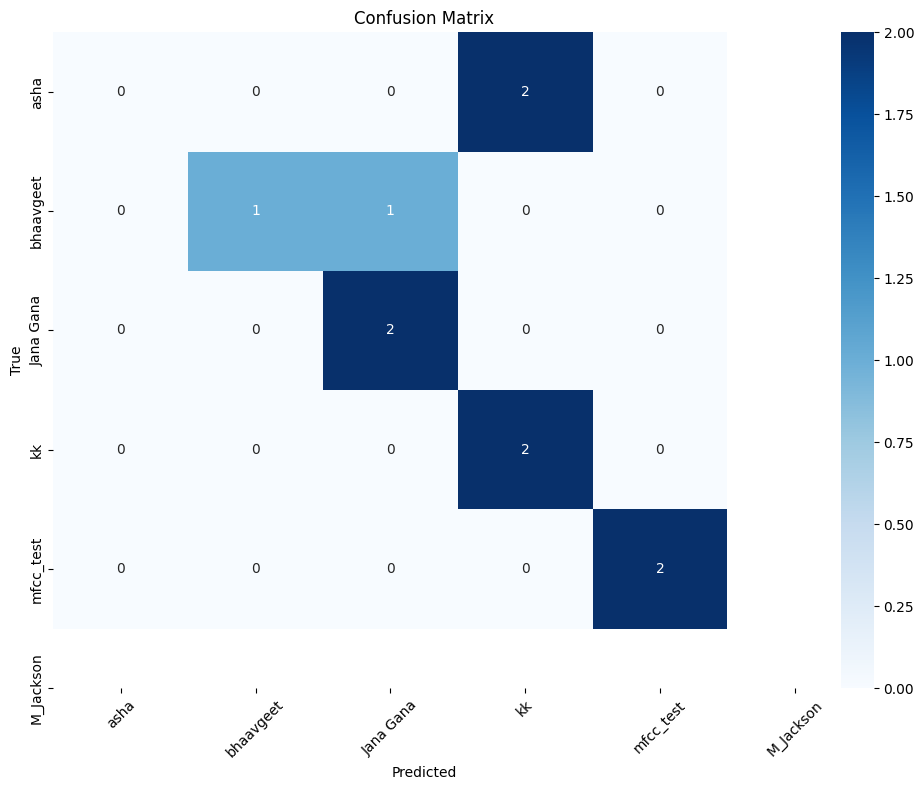


Model and scaler saved to files: 'svm_model.pkl' and 'scaler.pkl'


In [2]:
# # First cell - Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Second cell - Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Third cell - Load and process data
def load_mfcc_data(base_path, songs_per_folder=10):
    """
    Load MFCC data from CSV files
    Args:
        base_path: Path to data directory
        songs_per_folder: Number of songs to load from each folder
    """
    X = []  # Features
    y = []  # Labels
    
    # Dictionary to map folder names to numeric labels
    folders = ['asha', 'bhaavgeet mfcc', 'Jana Gana Mana', 'kk', 'lavani', 'mj']
    label_dict = {folder: idx for idx, folder in enumerate(folders)}
    
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        
        print(f"Processing folder: {folder}")
        
        # Take only the specified number of songs
        for file in files[:songs_per_folder]:
            file_path = os.path.join(folder_path, file)
            try:
                # Read CSV file
                data = pd.read_csv(file_path, header=None)
                
                # Skip first row and get MFCC coefficients
                mfcc_features = data.iloc[1:, :].values
                
                # Calculate basic statistical features
                features = np.concatenate([
                    np.mean(mfcc_features, axis=1),    # Mean of each coefficient
                    np.std(mfcc_features, axis=1),     # Standard deviation
                    np.min(mfcc_features, axis=1),     # Minimum values
                    np.max(mfcc_features, axis=1),     # Maximum values
                    np.median(mfcc_features, axis=1),  # Median values
                ])
                
                X.append(features)
                y.append(label_dict[folder])
                
            except Exception as e:
                print(f"Error processing file {file}: {str(e)}")
    
    return np.array(X), np.array(y)

# Fourth cell - Set path and load data
# Replace with your path
BASE_PATH = '/home/avdhoot/third_sem/ds203/project/neural_data'
print("Loading data...")
X, y = load_mfcc_data(BASE_PATH, songs_per_folder=20)
print(f"Loaded data shape: {X.shape}, {y.shape}")

# Fifth cell - Train SVM
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
print("\nTraining SVM...")
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)

# Evaluate
train_score = svm.score(X_train_scaled, y_train)
test_score = svm.score(X_test_scaled, y_test)

print("\nSVM Results:")
print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")

# Get predictions
y_pred = svm.predict(X_test_scaled)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Sixth cell - Visualize results
# Plot confusion matrix
folders = ['asha', 'bhaavgeet', 'Jana Gana', 'kk', 'mfcc_test', 'M_Jackson']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=folders,
            yticklabels=folders)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Save the model
import pickle

# Save the model and scaler
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nModel and scaler saved to files: 'svm_model.pkl' and 'scaler.pkl'")

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle

# Path to the folder containing the new MFCC CSV files
unlabeled_mfcc_folder = '/home/avdhoot/third_sem/ds203/project/MFCC-files-v2'  # Update with actual path

# Load the trained SVM model and scaler
with open('svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Function to process MFCC files without the initial sequence row
def process_mfcc_file(file_path):
    # Load the file
    data = pd.read_csv(file_path, header=None)
    
    # Directly access the 20 MFCC rows
    mfcc_features = data.values
    
    # Compute statistical features (mean, std, min, max, median)
    features = np.concatenate([
        np.mean(mfcc_features, axis=1),
        np.std(mfcc_features, axis=1),
        np.min(mfcc_features, axis=1),
        np.max(mfcc_features, axis=1),
        np.median(mfcc_features, axis=1),
    ])
    return features

# Prepare to load and predict
predictions = []
file_names = []

# Process each CSV in the folder and make predictions
for file_name in os.listdir(unlabeled_mfcc_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(unlabeled_mfcc_folder, file_name)
        features = process_mfcc_file(file_path)
        
        # Scale features and reshape for model input
        scaled_features = scaler.transform([features])
        
        # Predict the category
        predicted_label = svm_model.predict(scaled_features)[0]
        
        predictions.append(predicted_label)
        file_names.append(file_name)

# Display results
results_df = pd.DataFrame({'File': file_names, 'Predicted_Label': predictions})
print(results_df)

# Optionally, save predictions to a CSV file
results_df.to_csv('predicted_mfcc_labels.csv', index=False)
print("Predictions saved to 'predicted_mfcc_labels.csv'")


        File  Predicted_Label
0      3.csv                5
1    101.csv                0
2    108.csv                2
3     55.csv                2
4     42.csv                4
..       ...              ...
111    1.csv                2
112   19.csv                4
113   41.csv                4
114  103.csv                5
115   15.csv                4

[116 rows x 2 columns]
Predictions saved to 'predicted_mfcc_labels.csv'


Loading data...
Processing folder: asha
Processing folder: bhaavgeet mfcc
Processing folder: Jana Gana Mana
Processing folder: kk
Processing folder: lavani
Processing folder: mj
Loaded data shape: (100, 100), (100,)

Training SVM...

SVM Results:
Training accuracy: 0.9625
Testing accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       1.00      1.00      1.00         4
           2       0.80      1.00      0.89         4
           4       0.75      0.75      0.75         4
           5       1.00      1.00      1.00         4

    accuracy                           0.85        20
   macro avg       0.84      0.85      0.84        20
weighted avg       0.84      0.85      0.84        20



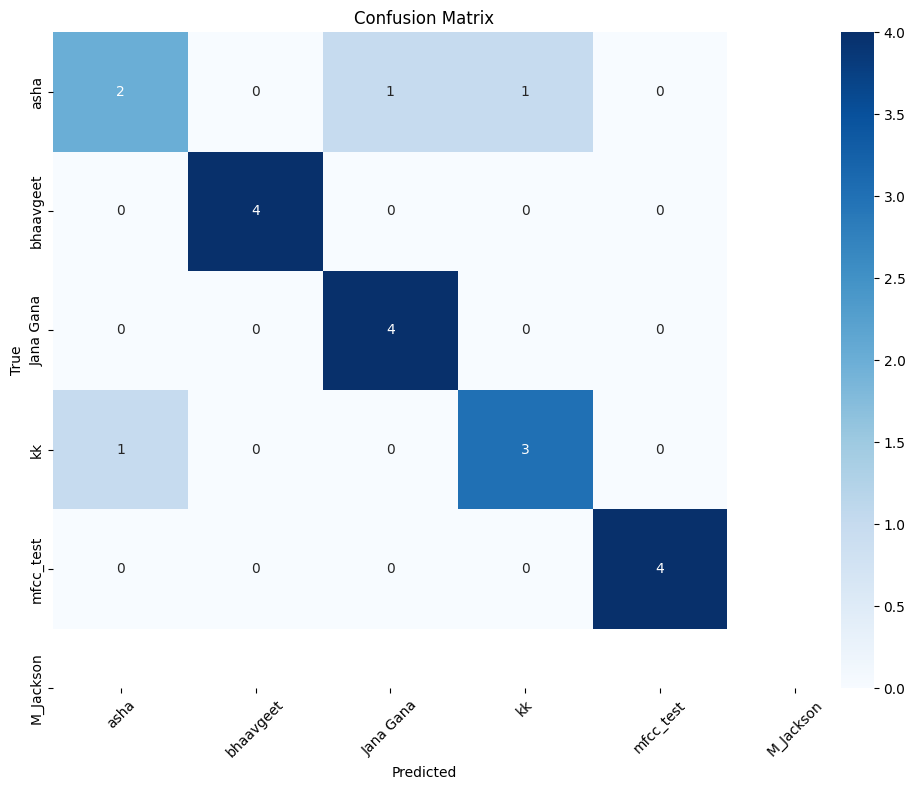


Model and scaler saved to files: 'svm_model.pkl' and 'scaler.pkl'


In [1]:
# # First cell - Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Second cell - Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Third cell - Load and process data
def load_mfcc_data(base_path, songs_per_folder=10):
    """
    Load MFCC data from CSV files
    Args:
        base_path: Path to data directory
        songs_per_folder: Number of songs to load from each folder
    """
    X = []  # Features
    y = []  # Labels
    
    # Dictionary to map folder names to numeric labels
    folders = ['asha', 'bhaavgeet mfcc', 'Jana Gana Mana', 'kk', 'lavani', 'mj']
    label_dict = {folder: idx for idx, folder in enumerate(folders)}
    
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        
        print(f"Processing folder: {folder}")
        
        # Take only the specified number of songs
        for file in files[:songs_per_folder]:
            file_path = os.path.join(folder_path, file)
            try:
                # Read CSV file
                data = pd.read_csv(file_path, header=None)
                
                # Skip first row and get MFCC coefficients
                mfcc_features = data.iloc[1:, :].values
                
                # Calculate basic statistical features
                features = np.concatenate([
                    np.mean(mfcc_features, axis=1),    # Mean of each coefficient
                    np.std(mfcc_features, axis=1),     # Standard deviation
                    np.min(mfcc_features, axis=1),     # Minimum values
                    np.max(mfcc_features, axis=1),     # Maximum values
                    np.median(mfcc_features, axis=1),  # Median values
                ])
                
                X.append(features)
                y.append(label_dict[folder])
                
            except Exception as e:
                print(f"Error processing file {file}: {str(e)}")
    
    return np.array(X), np.array(y)

# Fourth cell - Set path and load data
# Replace with your path
BASE_PATH = '/home/avdhoot/third_sem/ds203/project/neural_data'
print("Loading data...")
X, y = load_mfcc_data(BASE_PATH, songs_per_folder=20)
print(f"Loaded data shape: {X.shape}, {y.shape}")

# Fifth cell - Train SVM
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
print("\nTraining SVM...")
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)

# Evaluate
train_score = svm.score(X_train_scaled, y_train)
test_score = svm.score(X_test_scaled, y_test)

print("\nSVM Results:")
print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")

# Get predictions
y_pred = svm.predict(X_test_scaled)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Sixth cell - Visualize results
# Plot confusion matrix
folders = ['asha', 'bhaavgeet', 'Jana Gana', 'kk', 'mfcc_test', 'M_Jackson']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=folders,
            yticklabels=folders)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Save the model
import pickle

# Save the model and scaler
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nModel and scaler saved to files: 'svm_model.pkl' and 'scaler.pkl'")